# Results Comparison

This notebook compares model performance across different evaluation runs from `binary_results.json` or `multitype_result.json`.


## Configuration

Edit the settings below to customize your comparison.


In [7]:
# ========== CONFIGURATION - EDIT THESE SETTINGS ==========

# 1. Model names to compare (list of strings, or None for all models)
# Examples: 
#   MODEL_NAMES_TO_COMPARE = None  # Compare all models
#   MODEL_NAMES_TO_COMPARE = ["qwen2.5-7b", "ChatGPT 5.1"]  # Compare specific models
# MODEL_NAMES_TO_COMPARE = None  # Set to None for all models
MODEL_NAMES_TO_COMPARE = ["qwen2.5-7b"]

# 2. What to compare: "binary" or "multitype"
#   "binary": Uses binary_results.json, compares IPV vs NOT_IPV
#   "multitype": Uses multitype_result.json, compares emotional/physical/sexual abuse
COMPARISON_TYPE = "multitype"  # Options: "binary" or "multitype"

# 3. Date range filter (format: "YY-MM-DD" or None for all dates)
# Examples:
#   DATE_RANGE = None  # No date filter
#   DATE_RANGE = "25-11-20"  # Only results from 2025-11-20 onwards
DATE_RANGE = ["2025-11-20", "2025-11-21"]  # Date range from 2025-11-20 to 2025-11-25
# DATE_RANGE = None  # Set to None for all dates, or "YY-MM-DD" or [start, end]

# Paths to results files
BINARY_RESULTS_PATH = "results/binary_results.json"
MULTITYPE_RESULTS_PATH = "results/multitype_result.json"

# Output directory for saved plots
OUTPUT_DIR = "comparison_plots"

# =========================================================

print("Configuration:")
print(f"  Comparison Type: {COMPARISON_TYPE}")
print(f"  Models to Compare: {MODEL_NAMES_TO_COMPARE if MODEL_NAMES_TO_COMPARE else 'All models'}")
print(f"  Date Range: {DATE_RANGE if DATE_RANGE else 'All dates'}")


Configuration:
  Comparison Type: multitype
  Models to Compare: ['qwen2.5-7b']
  Date Range: ['2025-11-20', '2025-11-21']


## Import Dependencies


In [8]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from typing import List, Dict, Optional, Tuple
from collections import defaultdict

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

print("Dependencies loaded!")


Dependencies loaded!


## Load and Filter Results

In [9]:
def parse_date(date_str: str) -> Optional[datetime]:
    """Parse date string to datetime object."""
    if not date_str:
        return None
    try:
        # Try parsing YYYY-MM-DD HH:MM:SS format
        return datetime.strptime(date_str[:10], "%Y-%m-%d")
    except:
        try:
            # Try parsing YY-MM-DD format
            return datetime.strptime(date_str[:8], "%y-%m-%d")
        except:
            return None

def filter_by_date_range(date_str: str, date_range) -> bool:
    """Check if date_str falls within date_range."""
    if date_range is None:
        return True
    
    test_date = parse_date(date_str)
    if test_date is None:
        return True  # Include if date parsing fails
    
    if isinstance(date_range, str):
        # Single date - filter from this date onwards
        start_date = parse_date(date_range)
        if start_date is None:
            return True
        return test_date >= start_date
    elif isinstance(date_range, list) and len(date_range) == 2:
        # Date range
        start_date = parse_date(date_range[0])
        end_date = parse_date(date_range[1])
        if start_date is None or end_date is None:
            return True
        return start_date <= test_date <= end_date
    
    return True

# Load results based on comparison type
if COMPARISON_TYPE == "binary":
    results_path = Path(BINARY_RESULTS_PATH)
elif COMPARISON_TYPE == "multitype":
    results_path = Path(MULTITYPE_RESULTS_PATH)
else:
    raise ValueError(f"Invalid COMPARISON_TYPE: {COMPARISON_TYPE}. Must be 'binary' or 'multitype'")

if not results_path.exists():
    raise FileNotFoundError(f"Results file not found: {results_path}")

with open(results_path, 'r') as f:
    all_results = json.load(f)

print(f"Loaded {len(all_results)} total results from {results_path}")

# Filter results
filtered_results = []
for entry in all_results:
    # Filter by model name
    model_key = "model_name" if COMPARISON_TYPE == "binary" else "model"
    model_name = entry.get(model_key, "")
    
    if MODEL_NAMES_TO_COMPARE is not None:
        if model_name not in MODEL_NAMES_TO_COMPARE:
            continue
    
    # Filter by date range
    date_tested = entry.get("date_tested", "")
    if not filter_by_date_range(date_tested, DATE_RANGE):
        continue
    
    filtered_results.append(entry)

print(f"After filtering: {len(filtered_results)} results")

if len(filtered_results) == 0:
    raise ValueError("No results found after filtering. Check your configuration.")

# Display summary
model_key = "model_name" if COMPARISON_TYPE == "binary" else "model"
prompt_key = "prompt_version" if COMPARISON_TYPE == "binary" else "prompt_type"
unique_models = set(entry.get(model_key) for entry in filtered_results)
unique_prompts = set(entry.get(prompt_key) for entry in filtered_results)

print(f"\nUnique models: {sorted(unique_models)}")
print(f"Unique prompt types: {sorted(unique_prompts)}")

Loaded 6 total results from results/multitype_result.json
After filtering: 6 results

Unique models: ['qwen2.5-7b']
Unique prompt types: ['cot', 'fewshot', 'selfconsistency', 'zeroshot']


In [10]:
def parse_date(date_str: str) -> Optional[datetime]:
    """Parse date string to datetime object."""
    if not date_str:
        return None
    try:
        return datetime.strptime(date_str[:10], "%Y-%m-%d")
    except:
        try:
            return datetime.strptime(date_str[:8], "%y-%m-%d")
        except:
            return None

def filter_by_date_range(date_str: str, date_range) -> bool:
    """Check if date_str falls within date_range."""
    if date_range is None:
        return True
    
    test_date = parse_date(date_str)
    if test_date is None:
        return True
    
    if isinstance(date_range, str):
        start_date = parse_date(date_range)
        if start_date is None:
            return True
        return test_date >= start_date
    elif isinstance(date_range, list) and len(date_range) == 2:
        start_date = parse_date(date_range[0])
        end_date = parse_date(date_range[1])
        if start_date is None or end_date is None:
            return True
        return start_date <= test_date <= end_date
    
    return True

# Load results based on comparison type
if COMPARISON_TYPE == "binary":
    results_path = Path(BINARY_RESULTS_PATH)
elif COMPARISON_TYPE == "multitype":
    results_path = Path(MULTITYPE_RESULTS_PATH)
else:
    raise ValueError(f"Invalid COMPARISON_TYPE: {COMPARISON_TYPE}. Must be 'binary' or 'multitype'")

if not results_path.exists():
    raise FileNotFoundError(f"Results file not found: {results_path}")

with open(results_path, 'r') as f:
    all_results = json.load(f)

print(f"Loaded {len(all_results)} total results from {results_path}")

# Filter results
filtered_results = []
for entry in all_results:
    model_key = "model_name" if COMPARISON_TYPE == "binary" else "model"
    model_name = entry.get(model_key, "")
    
    if MODEL_NAMES_TO_COMPARE is not None:
        if model_name not in MODEL_NAMES_TO_COMPARE:
            continue
    
    date_tested = entry.get("date_tested", "")
    if not filter_by_date_range(date_tested, DATE_RANGE):
        continue
    
    filtered_results.append(entry)

print(f"After filtering: {len(filtered_results)} results")

if len(filtered_results) == 0:
    raise ValueError("No results found after filtering. Check your configuration.")

# Display summary
model_key = "model_name" if COMPARISON_TYPE == "binary" else "model"
prompt_key = "prompt_version" if COMPARISON_TYPE == "binary" else "prompt_type"
unique_models = set(entry.get(model_key) for entry in filtered_results)
unique_prompts = set(entry.get(prompt_key) for entry in filtered_results)

print(f"\nUnique models: {sorted(unique_models)}")
print(f"Unique prompt types: {sorted(unique_prompts)}")


Loaded 6 total results from results/multitype_result.json
After filtering: 6 results

Unique models: ['qwen2.5-7b']
Unique prompt types: ['cot', 'fewshot', 'selfconsistency', 'zeroshot']


## Binary Comparison Visualizations


In [11]:
if COMPARISON_TYPE == "binary":
    # Prepare data for binary comparison
    data_rows = []
    for entry in filtered_results:
        model_name = entry.get("model_name", "unknown")
        prompt_version = entry.get("prompt_version", "unknown")
        metrics = entry.get("metrics", {})
        date_tested = entry.get("date_tested", "")
        
        row = {
            "model_name": model_name,
            "prompt_version": prompt_version,
            "label": f"{model_name} ({prompt_version})",
            "date_tested": date_tested,
            **metrics
        }
        data_rows.append(row)
    
    df = pd.DataFrame(data_rows)
    print(f"Binary comparison data prepared: {len(df)} entries")
    metric_columns = [col for col in df.columns if col not in ['model_name', 'prompt_version', 'label', 'date_tested']]
    print(f"Available metrics: {metric_columns}")
    print(f"\nData preview:")
    print(df.head())


## Multitype Comparison Visualizations


In [12]:
if COMPARISON_TYPE == "multitype":
    # Prepare data for multitype comparison
    data_rows = []
    for entry in filtered_results:
        model_name = entry.get("model", "unknown")
        prompt_type = entry.get("prompt_type", "unknown")
        metrics = entry.get("metrics", {})
        date_tested = entry.get("date_tested", "")
        
        # Extract metrics for each IPV type
        for ipv_type in ["physical", "emotional", "sexual"]:
            if ipv_type in metrics:
                type_metrics = metrics[ipv_type]
                row = {
                    "model_name": model_name,
                    "prompt_type": prompt_type,
                    "label": f"{model_name} ({prompt_type})",
                    "ipv_type": ipv_type,
                    "date_tested": date_tested,
                    **type_metrics  # Unpack accuracy, precision, recall, f1, etc.
                }
                data_rows.append(row)
    
    df_multitype = pd.DataFrame(data_rows)
    
    print(f"Multitype comparison data prepared: {len(df_multitype)} entries")
    print(f"\nIPV Types: {df_multitype['ipv_type'].unique().tolist()}")
    metric_columns = [col for col in df_multitype.columns if col not in ['model_name', 'prompt_type', 'label', 'ipv_type', 'date_tested']
                     and col not in ['true_positives', 'false_positives', 'true_negatives', 'false_negatives']]
    print(f"Available metrics: {metric_columns}")
    print(f"\nData preview:")
    print(df_multitype.head(10))


Multitype comparison data prepared: 18 entries

IPV Types: ['physical', 'emotional', 'sexual']
Available metrics: ['accuracy', 'precision', 'recall', 'f1']

Data preview:
   model_name prompt_type                  label   ipv_type  \
0  qwen2.5-7b    zeroshot  qwen2.5-7b (zeroshot)   physical   
1  qwen2.5-7b    zeroshot  qwen2.5-7b (zeroshot)  emotional   
2  qwen2.5-7b    zeroshot  qwen2.5-7b (zeroshot)     sexual   
3  qwen2.5-7b     fewshot   qwen2.5-7b (fewshot)   physical   
4  qwen2.5-7b     fewshot   qwen2.5-7b (fewshot)  emotional   
5  qwen2.5-7b     fewshot   qwen2.5-7b (fewshot)     sexual   
6  qwen2.5-7b         cot       qwen2.5-7b (cot)   physical   
7  qwen2.5-7b         cot       qwen2.5-7b (cot)  emotional   
8  qwen2.5-7b         cot       qwen2.5-7b (cot)     sexual   
9  qwen2.5-7b         cot       qwen2.5-7b (cot)   physical   

           date_tested  accuracy  precision    recall        f1  \
0  2025-11-20 23:44:04  0.941748   0.771429  0.729730  0.750000   
1

### 1. Compare Models Across IPV Types (Grouped Bar Charts)


Saved plot → comparison_plots/multitype_comparison_all_metrics.png


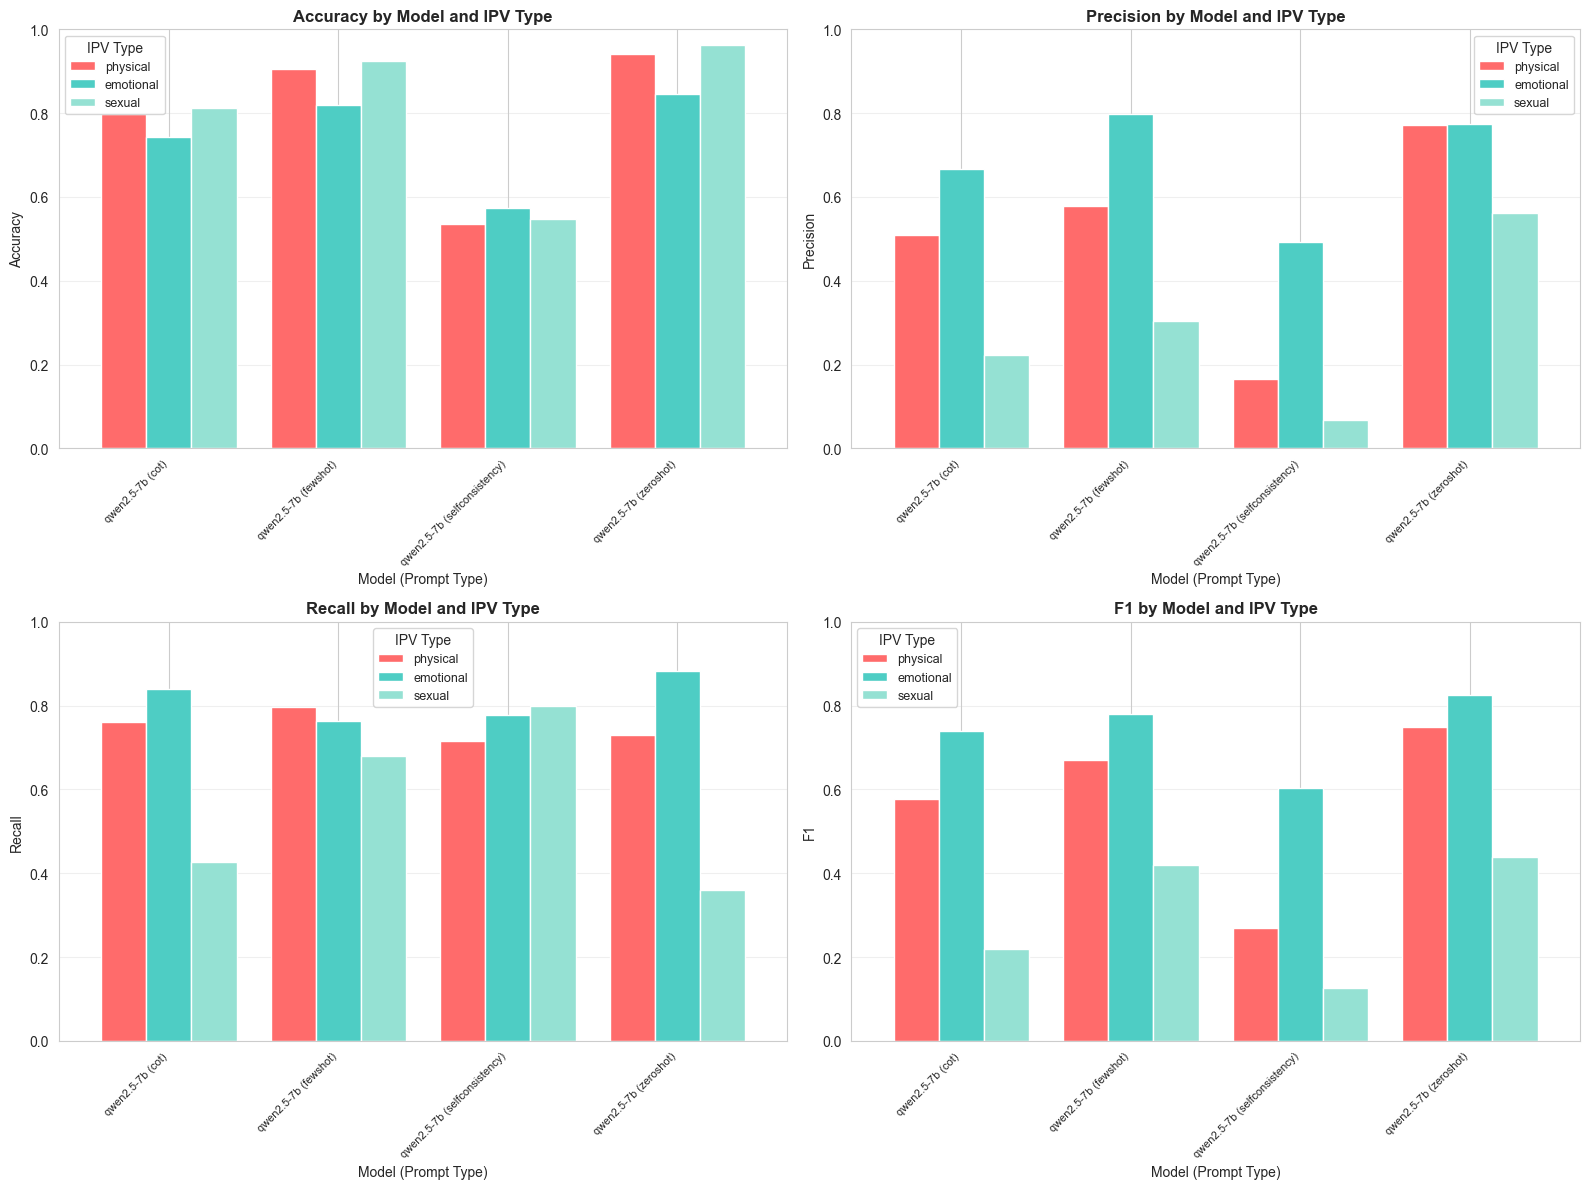

In [13]:
if COMPARISON_TYPE == "multitype":
    # Compare models across IPV types for each metric
    metrics_to_plot = [m for m in ['accuracy', 'precision', 'recall', 'f1'] if m in df_multitype.columns]
    
    if len(metrics_to_plot) > 0:
        n_metrics = len(metrics_to_plot)
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for ax, metric in zip(axes[:n_metrics], metrics_to_plot):
            # Create grouped bar chart: IPV type × Model
            pivot = df_multitype.pivot_table(
                values=metric,
                index='label',
                columns='ipv_type',
                aggfunc='mean'
            )
            
            # Reorder columns to be: physical, emotional, sexual
            col_order = ['physical', 'emotional', 'sexual']
            pivot = pivot[[col for col in col_order if col in pivot.columns]]
            
            pivot.plot(kind='bar', ax=ax, width=0.8, color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
            ax.set_title(f"{metric.capitalize()} by Model and IPV Type", fontsize=12, fontweight='bold')
            ax.set_xlabel('Model (Prompt Type)', fontsize=10)
            ax.set_ylabel(metric.capitalize(), fontsize=10)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
            ax.legend(title='IPV Type', fontsize=9, title_fontsize=10)
            ax.grid(axis='y', alpha=0.3)
            ax.set_ylim(0, 1)
        
        # Remove extra subplots
        for ax in axes[n_metrics:]:
            ax.remove()
        
        plt.tight_layout()
        
        # Save plot
        Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
        save_path = Path(OUTPUT_DIR) / "multitype_comparison_all_metrics.png"
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Saved plot → {save_path}")
        
        plt.show()
        plt.close()
    else:
        print("No metrics found to plot!")


### 2. Compare Models for Each IPV Type Separately


Saved plot → comparison_plots/multitype_physical_comparison.png


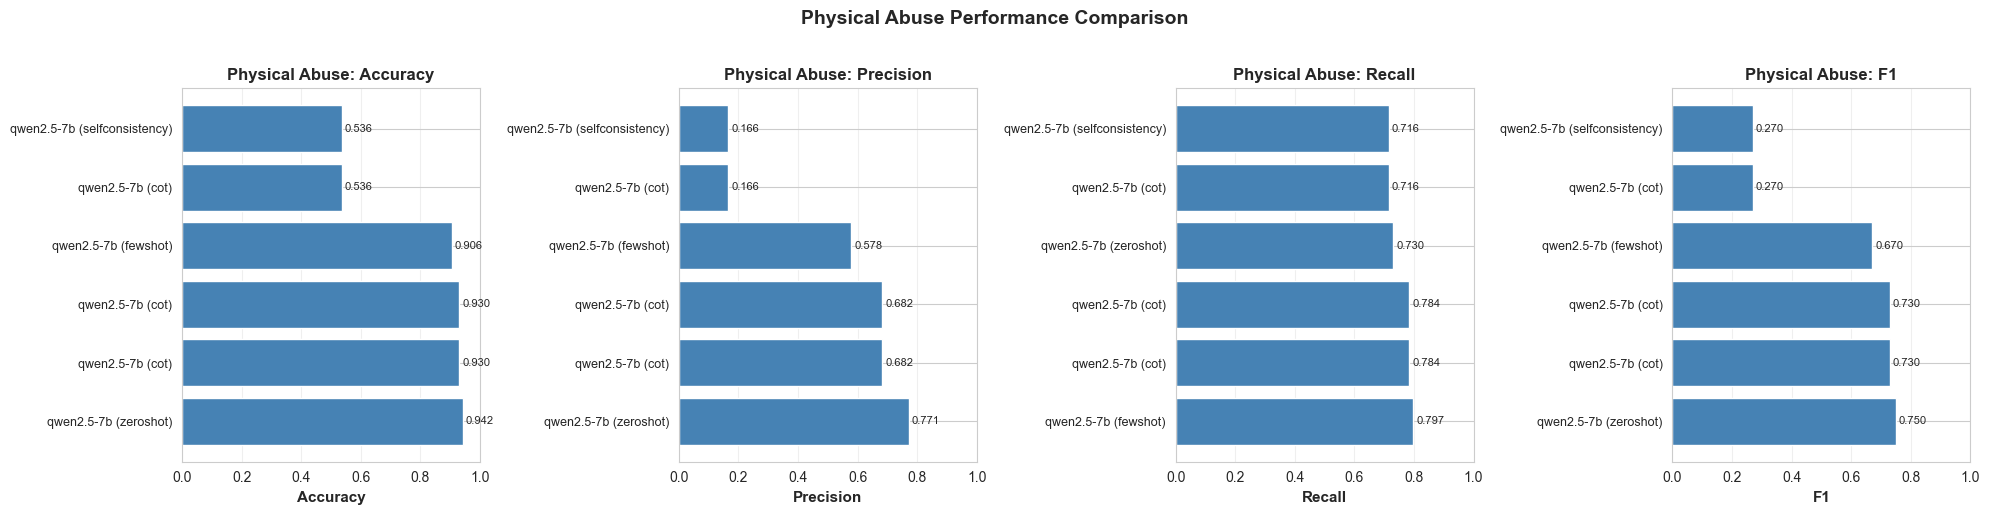

Saved plot → comparison_plots/multitype_emotional_comparison.png


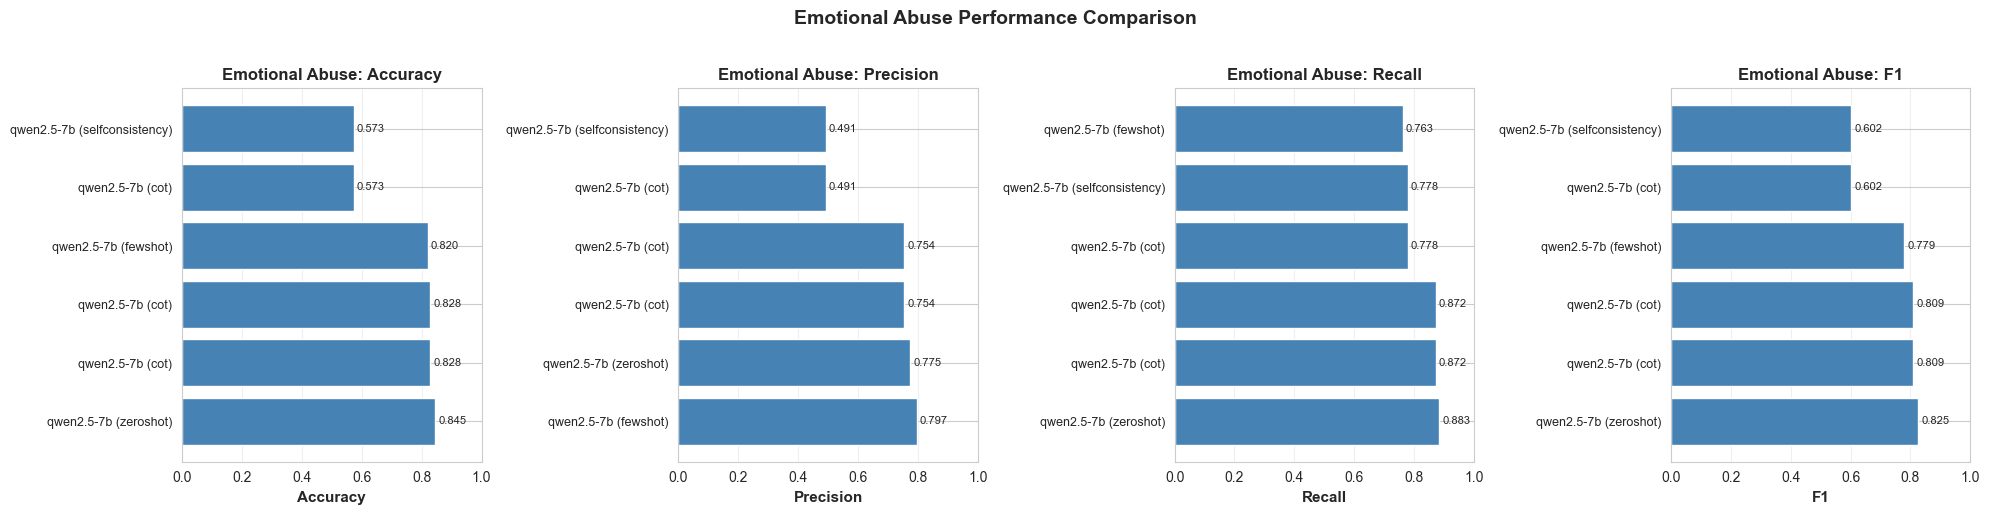

Saved plot → comparison_plots/multitype_sexual_comparison.png


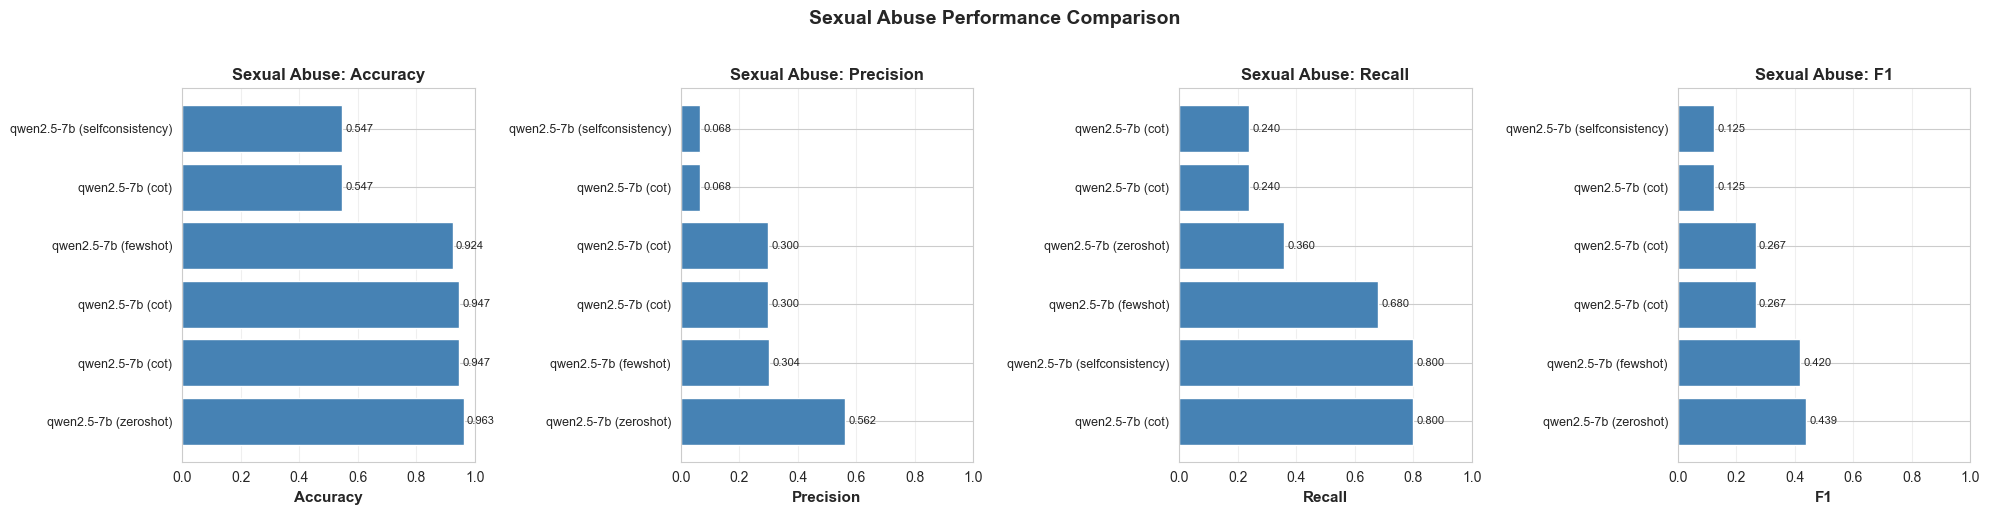

In [14]:
if COMPARISON_TYPE == "multitype":
    # Compare each IPV type separately across models
    ipv_types = ['physical', 'emotional', 'sexual']
    metrics_to_plot = [m for m in ['accuracy', 'precision', 'recall', 'f1'] if m in df_multitype.columns]
    
    if len(metrics_to_plot) > 0:
        for ipv_type in ipv_types:
            if ipv_type not in df_multitype['ipv_type'].values:
                continue
                
            df_type = df_multitype[df_multitype['ipv_type'] == ipv_type]
            
            n_metrics = len(metrics_to_plot)
            fig, axes = plt.subplots(1, n_metrics, figsize=(5 * n_metrics, 5))
            if n_metrics == 1:
                axes = [axes]
            
            for ax, metric in zip(axes, metrics_to_plot):
                # Sort by metric value
                df_sorted = df_type.sort_values(metric, ascending=False)
                
                # Create bars
                bars = ax.barh(range(len(df_sorted)), df_sorted[metric].values, color='steelblue')
                ax.set_yticks(range(len(df_sorted)))
                ax.set_yticklabels(df_sorted['label'].values, fontsize=9)
                ax.set_xlabel(metric.capitalize(), fontsize=11, fontweight='bold')
                ax.set_title(f"{ipv_type.capitalize()} Abuse: {metric.capitalize()}", fontsize=12, fontweight='bold')
                ax.set_xlim(0, 1)
                ax.grid(axis='x', alpha=0.3)
                
                # Add value labels
                for i, (bar, val) in enumerate(zip(bars, df_sorted[metric].values)):
                    width = bar.get_width()
                    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                           f'{val:.3f}',
                           ha='left', va='center', fontsize=8)
            
            plt.suptitle(f"{ipv_type.capitalize()} Abuse Performance Comparison", fontsize=14, fontweight='bold', y=1.02)
            plt.tight_layout()
            
            # Save plot
            Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
            save_path = Path(OUTPUT_DIR) / f"multitype_{ipv_type}_comparison.png"
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
            print(f"Saved plot → {save_path}")
            
            plt.show()
            plt.close()


### 3. Heatmap: Model × IPV Type for Each Metric


Saved plot → comparison_plots/multitype_heatmap_all_metrics.png


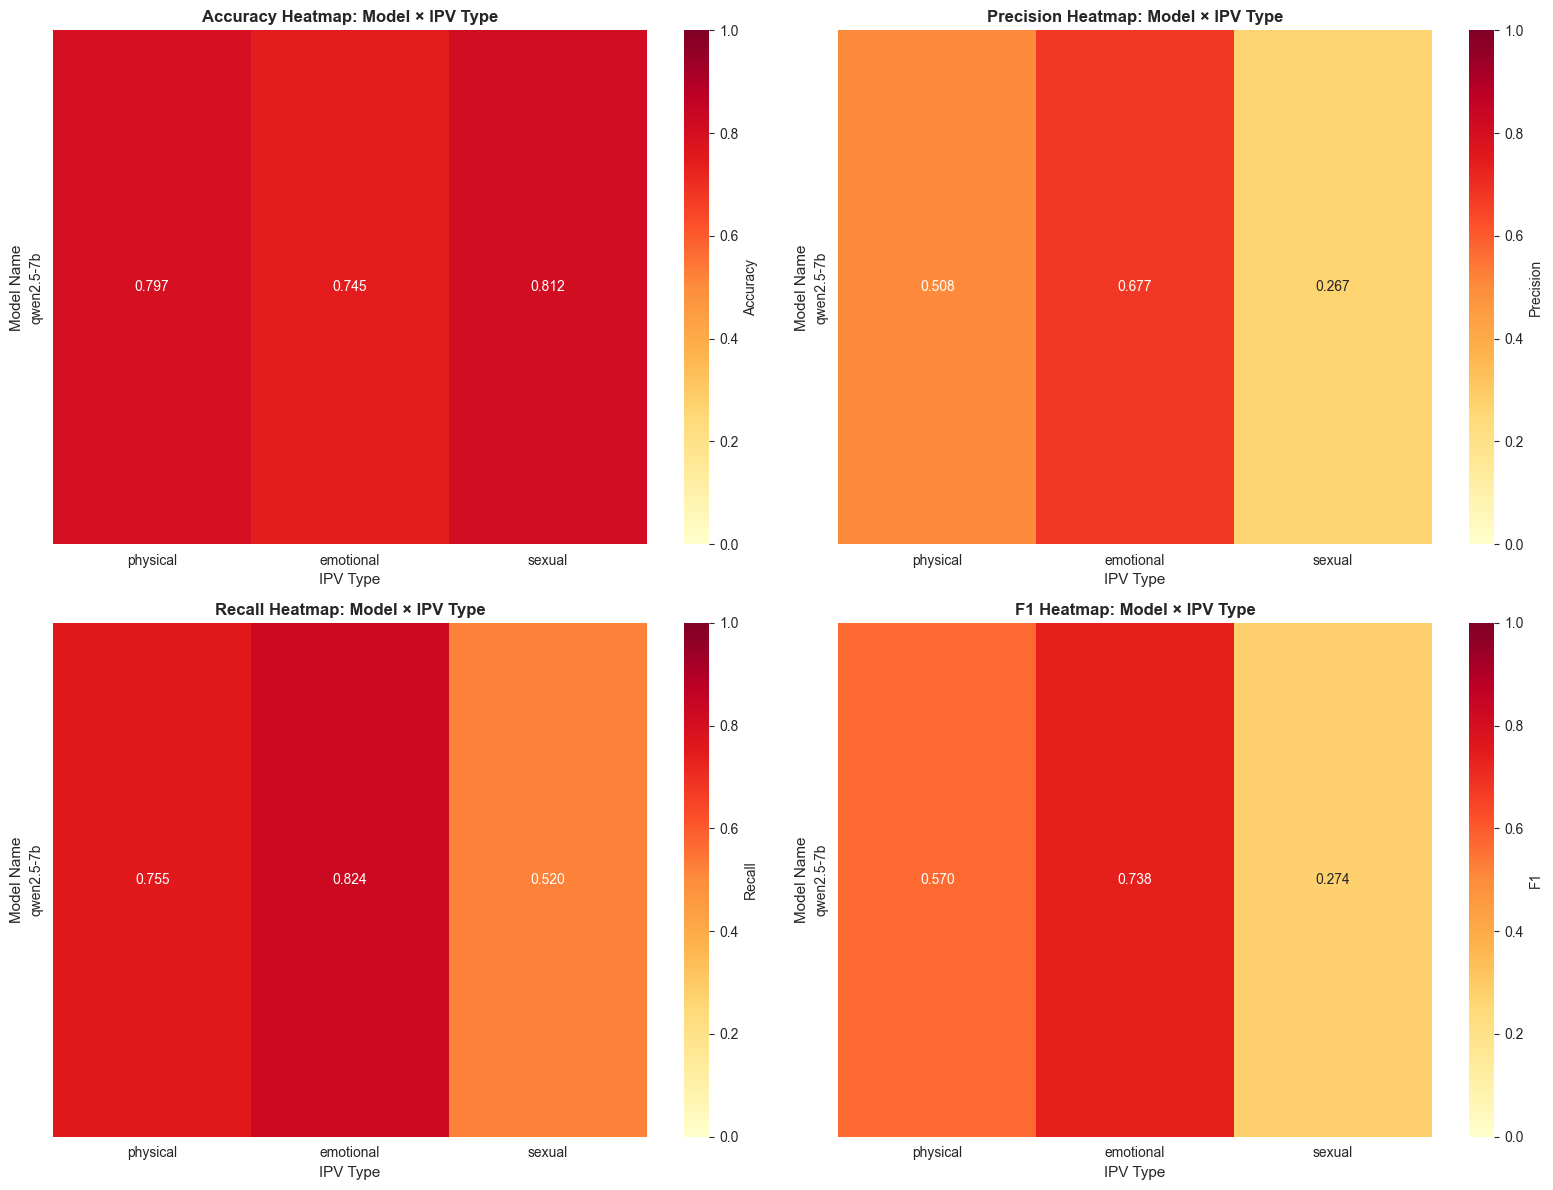

In [15]:
if COMPARISON_TYPE == "multitype":
    # Heatmap: Model × IPV Type for each metric
    metrics_to_plot = [m for m in ['accuracy', 'precision', 'recall', 'f1'] if m in df_multitype.columns]
    
    if len(metrics_to_plot) > 0:
        n_metrics = len(metrics_to_plot)
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for ax, metric in zip(axes[:n_metrics], metrics_to_plot):
            # Create pivot: Model × IPV Type
            pivot = df_multitype.pivot_table(
                values=metric,
                index='model_name',
                columns='ipv_type',
                aggfunc='mean'
            )
            
            # Reorder columns
            col_order = ['physical', 'emotional', 'sexual']
            pivot = pivot[[col for col in col_order if col in pivot.columns]]
            
            if not pivot.empty:
                sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax,
                          cbar_kws={'label': metric.capitalize()}, vmin=0, vmax=1)
                ax.set_title(f"{metric.capitalize()} Heatmap: Model × IPV Type", fontsize=12, fontweight='bold')
                ax.set_xlabel('IPV Type', fontsize=11)
                ax.set_ylabel('Model Name', fontsize=11)
        
        # Remove extra subplots
        for ax in axes[n_metrics:]:
            ax.remove()
        
        plt.tight_layout()
        
        # Save plot
        Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
        save_path = Path(OUTPUT_DIR) / "multitype_heatmap_all_metrics.png"
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Saved plot → {save_path}")
        
        plt.show()
        plt.close()


### 4. Best Model Summary Table


In [16]:
if COMPARISON_TYPE == "multitype":
    # Summary table: Best model for each IPV type and metric
    print("\n" + "="*80)
    print("BEST MODEL FOR EACH IPV TYPE AND METRIC")
    print("="*80)
    
    metrics_to_analyze = [m for m in ['accuracy', 'precision', 'recall', 'f1'] if m in df_multitype.columns]
    
    summary_data = []
    for ipv_type in ['physical', 'emotional', 'sexual']:
        if ipv_type not in df_multitype['ipv_type'].values:
            continue
        
        df_type = df_multitype[df_multitype['ipv_type'] == ipv_type]
        
        for metric in metrics_to_analyze:
            best_idx = df_type[metric].idxmax()
            best_row = df_type.loc[best_idx]
            
            summary_data.append({
                'IPV Type': ipv_type.capitalize(),
                'Metric': metric.capitalize(),
                'Best Model': best_row['label'],
                'Score': f"{best_row[metric]:.4f}",
            })
    
    summary_df = pd.DataFrame(summary_data)
    print("\n" + summary_df.to_string(index=False))
    
    # Save summary to CSV
    Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
    summary_path = Path(OUTPUT_DIR) / "multitype_best_models_summary.csv"
    summary_df.to_csv(summary_path, index=False)
    print(f"\nSummary saved to: {summary_path}")



BEST MODEL FOR EACH IPV TYPE AND METRIC

 IPV Type    Metric            Best Model  Score
 Physical  Accuracy qwen2.5-7b (zeroshot) 0.9417
 Physical Precision qwen2.5-7b (zeroshot) 0.7714
 Physical    Recall  qwen2.5-7b (fewshot) 0.7973
 Physical        F1 qwen2.5-7b (zeroshot) 0.7500
Emotional  Accuracy qwen2.5-7b (zeroshot) 0.8447
Emotional Precision  qwen2.5-7b (fewshot) 0.7967
Emotional    Recall qwen2.5-7b (zeroshot) 0.8833
Emotional        F1 qwen2.5-7b (zeroshot) 0.8255
   Sexual  Accuracy qwen2.5-7b (zeroshot) 0.9628
   Sexual Precision qwen2.5-7b (zeroshot) 0.5625
   Sexual    Recall      qwen2.5-7b (cot) 0.8000
   Sexual        F1 qwen2.5-7b (zeroshot) 0.4390

Summary saved to: comparison_plots/multitype_best_models_summary.csv


### 5. Additional Comparison: Prompt Type Performance Across IPV Types


Saved plot → comparison_plots/multitype_prompt_type_comparison.png


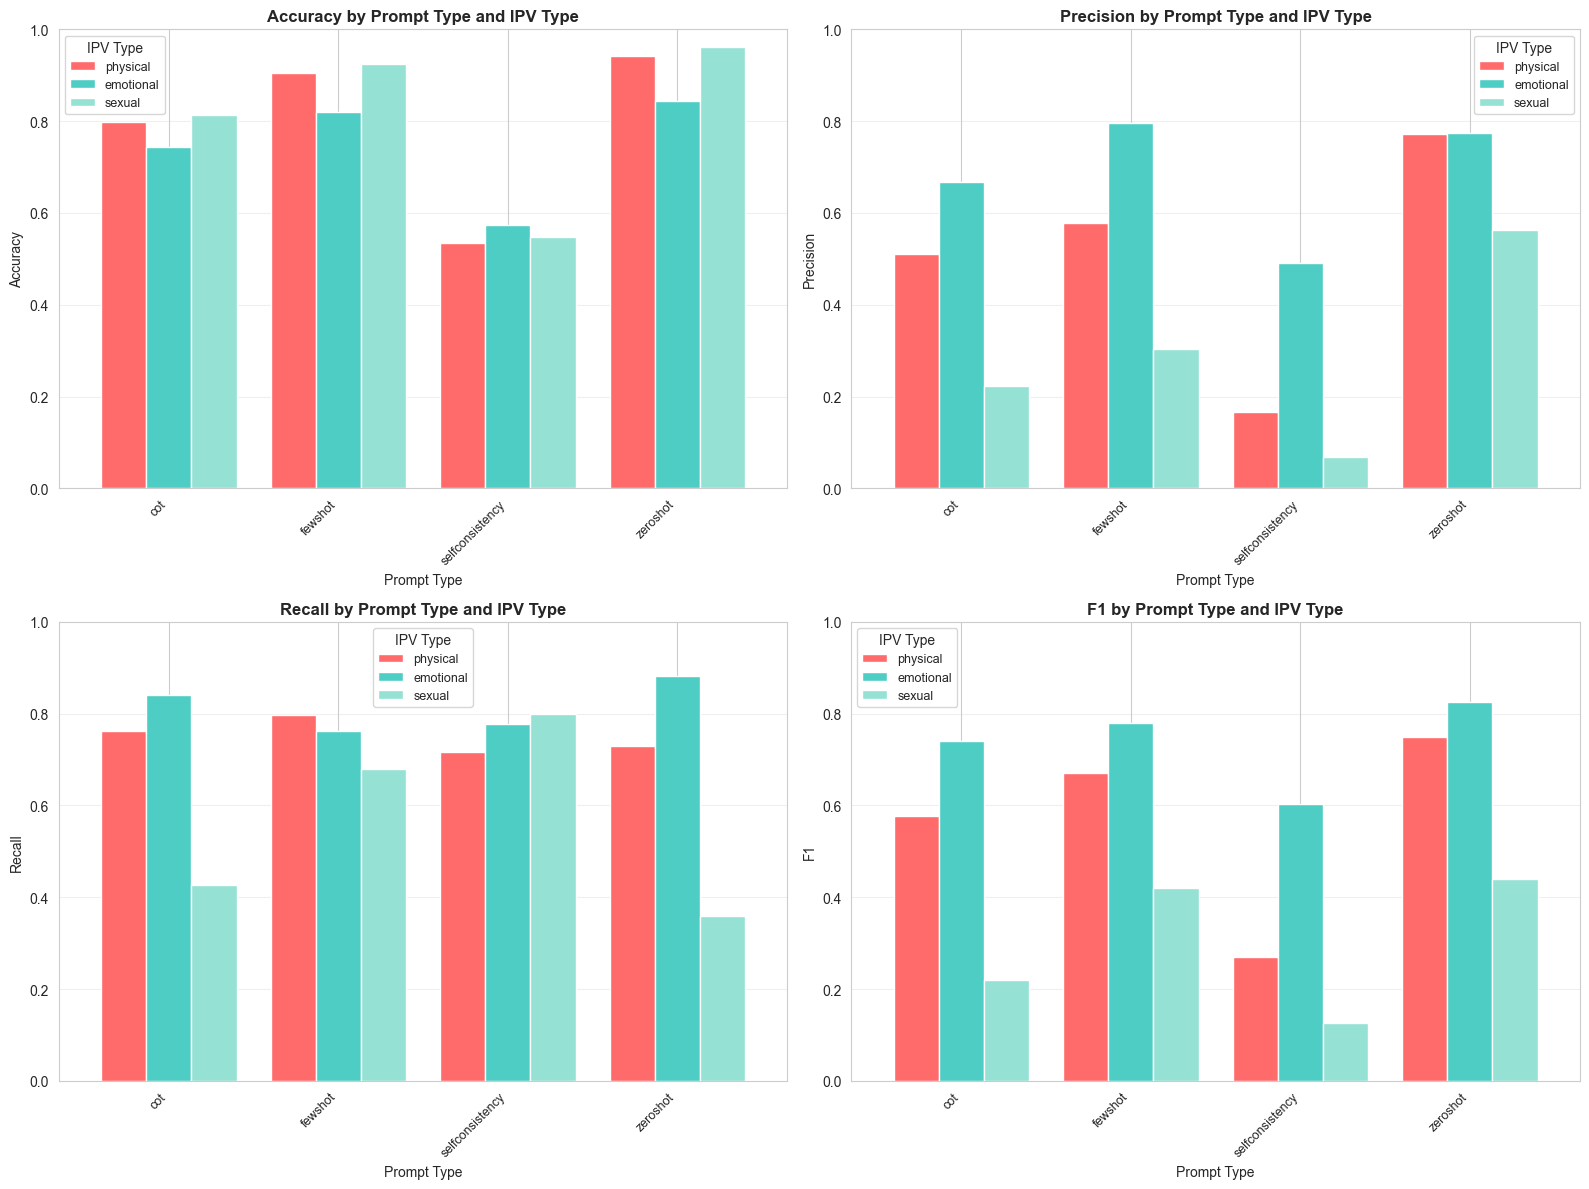

In [17]:
if COMPARISON_TYPE == "multitype":
    # Compare prompt types across IPV types
    metrics_to_plot = [m for m in ['accuracy', 'precision', 'recall', 'f1'] if m in df_multitype.columns]
    
    if len(metrics_to_plot) > 0:
        n_metrics = len(metrics_to_plot)
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for ax, metric in zip(axes[:n_metrics], metrics_to_plot):
            # Create pivot: Prompt Type × IPV Type
            pivot = df_multitype.pivot_table(
                values=metric,
                index='prompt_type',
                columns='ipv_type',
                aggfunc='mean'
            )
            
            # Reorder columns
            col_order = ['physical', 'emotional', 'sexual']
            pivot = pivot[[col for col in col_order if col in pivot.columns]]
            
            pivot.plot(kind='bar', ax=ax, width=0.8, color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
            ax.set_title(f"{metric.capitalize()} by Prompt Type and IPV Type", fontsize=12, fontweight='bold')
            ax.set_xlabel('Prompt Type', fontsize=10)
            ax.set_ylabel(metric.capitalize(), fontsize=10)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
            ax.legend(title='IPV Type', fontsize=9, title_fontsize=10)
            ax.grid(axis='y', alpha=0.3)
            ax.set_ylim(0, 1)
        
        # Remove extra subplots
        for ax in axes[n_metrics:]:
            ax.remove()
        
        plt.tight_layout()
        
        # Save plot
        Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
        save_path = Path(OUTPUT_DIR) / "multitype_prompt_type_comparison.png"
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Saved plot → {save_path}")
        
        plt.show()
        plt.close()


## Summary Statistics


In [18]:
# Print summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

if COMPARISON_TYPE == "binary":
    print(f"\nComparison Type: Binary Classification")
    print(f"Total Results: {len(df)}")
    print(f"Unique Models: {df['model_name'].nunique()}")
    print(f"Unique Prompt Versions: {df['prompt_version'].nunique()}")
    
    if 'Accuracy' in df.columns:
        print(f"\nAccuracy Range: {df['Accuracy'].min():.3f} - {df['Accuracy'].max():.3f}")
        print(f"Average Accuracy: {df['Accuracy'].mean():.3f}")
    if 'F1' in df.columns:
        print(f"F1 Range: {df['F1'].min():.3f} - {df['F1'].max():.3f}")
        print(f"Average F1: {df['F1'].mean():.3f}")
        
elif COMPARISON_TYPE == "multitype":
    print(f"\nComparison Type: Multitype Classification")
    print(f"Total Results: {len(df_multitype)}")
    print(f"Unique Models: {df_multitype['model_name'].nunique()}")
    print(f"Unique Prompt Types: {df_multitype['prompt_type'].nunique()}")
    print(f"IPV Types Analyzed: {sorted(df_multitype['ipv_type'].unique())}")
    
    if 'accuracy' in df_multitype.columns:
        print(f"\nAccuracy by IPV Type:")
        for ipv_type in ['physical', 'emotional', 'sexual']:
            if ipv_type in df_multitype['ipv_type'].values:
                df_type = df_multitype[df_multitype['ipv_type'] == ipv_type]
                print(f"  {ipv_type.capitalize()}: {df_type['accuracy'].min():.3f} - {df_type['accuracy'].max():.3f} (avg: {df_type['accuracy'].mean():.3f})")
    
    if 'f1' in df_multitype.columns:
        print(f"\nF1 by IPV Type:")
        for ipv_type in ['physical', 'emotional', 'sexual']:
            if ipv_type in df_multitype['ipv_type'].values:
                df_type = df_multitype[df_multitype['ipv_type'] == ipv_type]
                print(f"  {ipv_type.capitalize()}: {df_type['f1'].min():.3f} - {df_type['f1'].max():.3f} (avg: {df_type['f1'].mean():.3f})")

print("\n" + "="*80)



SUMMARY STATISTICS

Comparison Type: Multitype Classification
Total Results: 18
Unique Models: 1
Unique Prompt Types: 4
IPV Types Analyzed: ['emotional', 'physical', 'sexual']

Accuracy by IPV Type:
  Physical: 0.536 - 0.942 (avg: 0.797)
  Emotional: 0.573 - 0.845 (avg: 0.745)
  Sexual: 0.547 - 0.963 (avg: 0.812)

F1 by IPV Type:
  Physical: 0.270 - 0.750 (avg: 0.570)
  Emotional: 0.602 - 0.825 (avg: 0.738)
  Sexual: 0.125 - 0.439 (avg: 0.274)



### 6. Overall Performance: Macro-Averaged Metrics Across All IPV Types


Overall Performance (Macro-Averaged Across All IPV Types):
                       label model_name     prompt_type  macro_accuracy  macro_precision  macro_recall  macro_f1
       qwen2.5-7b (zeroshot) qwen2.5-7b        zeroshot        0.916397         0.702891      0.657666  0.671493
        qwen2.5-7b (fewshot) qwen2.5-7b         fewshot        0.883495         0.559584      0.746648  0.623177
            qwen2.5-7b (cot) qwen2.5-7b             cot        0.785149         0.466496      0.676132  0.511879
qwen2.5-7b (selfconsistency) qwen2.5-7b selfconsistency        0.551780         0.241780      0.764809  0.332377

Saved plot → comparison_plots/multitype_overall_performance.png


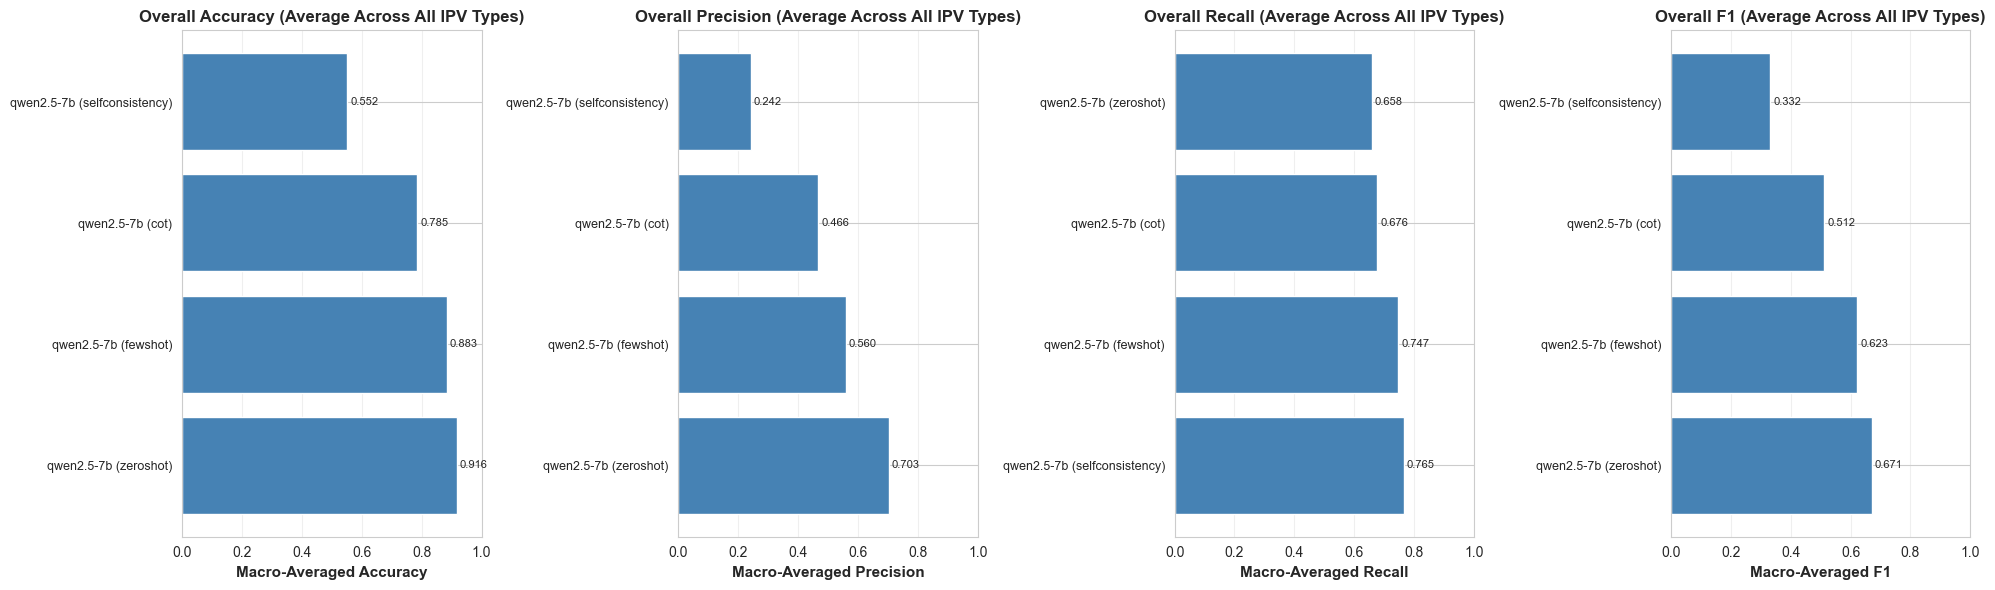

Overall performance data saved to: comparison_plots/multitype_overall_performance.csv


In [19]:
if COMPARISON_TYPE == "multitype":
    # Calculate macro-averaged metrics across all IPV types for each model-prompt combination
    overall_rows = []
    
    for label in df_multitype['label'].unique():
        df_label = df_multitype[df_multitype['label'] == label]
        
        row = {
            'label': label,
            'model_name': df_label['model_name'].iloc[0],
            'prompt_type': df_label['prompt_type'].iloc[0],
        }
        
        # Calculate macro-averaged metrics (average across all IPV types)
        for metric in ['accuracy', 'precision', 'recall', 'f1']:
            if metric in df_label.columns:
                row[f'macro_{metric}'] = df_label[metric].mean()
        
        overall_rows.append(row)
    
    df_overall = pd.DataFrame(overall_rows)
    
    print("Overall Performance (Macro-Averaged Across All IPV Types):")
    print("="*80)
    print(df_overall.to_string(index=False))
    
    # Visualize overall performance
    metrics_to_plot = [col for col in df_overall.columns if col.startswith('macro_')]
    
    if len(metrics_to_plot) > 0:
        # Rename columns for display
        display_metrics = [m.replace('macro_', '').capitalize() for m in metrics_to_plot]
        
        n_metrics = len(metrics_to_plot)
        fig, axes = plt.subplots(1, n_metrics, figsize=(5 * n_metrics, 6))
        if n_metrics == 1:
            axes = [axes]
        
        for ax, metric_col in zip(axes, metrics_to_plot):
            df_sorted = df_overall.sort_values(metric_col, ascending=False)
            metric_name = metric_col.replace('macro_', '').capitalize()
            
            bars = ax.barh(range(len(df_sorted)), df_sorted[metric_col].values, color='steelblue')
            ax.set_yticks(range(len(df_sorted)))
            ax.set_yticklabels(df_sorted['label'].values, fontsize=9)
            ax.set_xlabel(f'Macro-Averaged {metric_name}', fontsize=11, fontweight='bold')
            ax.set_title(f"Overall {metric_name} (Average Across All IPV Types)", fontsize=12, fontweight='bold')
            ax.set_xlim(0, 1)
            ax.grid(axis='x', alpha=0.3)
            
            # Add value labels
            for bar, val in zip(bars, df_sorted[metric_col].values):
                width = bar.get_width()
                ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                       f'{val:.3f}', ha='left', va='center', fontsize=8)
        
        plt.tight_layout()
        
        # Save plot
        Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
        save_path = Path(OUTPUT_DIR) / "multitype_overall_performance.png"
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"\nSaved plot → {save_path}")
        
        plt.show()
        plt.close()
        
        # Save overall performance to CSV
        overall_path = Path(OUTPUT_DIR) / "multitype_overall_performance.csv"
        df_overall.to_csv(overall_path, index=False)
        print(f"Overall performance data saved to: {overall_path}")


In [20]:
if COMPARISON_TYPE == "binary":
    # Create comparison plots for binary results
    metric_columns = [col for col in df.columns if col not in ['model_name', 'prompt_version', 'label', 'date_tested']]
    
    if len(metric_columns) > 0:
        n_metrics = len(metric_columns)
        fig, axes = plt.subplots(1, n_metrics, figsize=(6 * n_metrics, 6))
        if n_metrics == 1:
            axes = [axes]
        
        for ax, metric in zip(axes, metric_columns):
            df_sorted = df.sort_values(metric, ascending=False)
            bars = ax.barh(range(len(df_sorted)), df_sorted[metric].values, color='steelblue')
            ax.set_yticks(range(len(df_sorted)))
            ax.set_yticklabels(df_sorted['label'].values, fontsize=9)
            ax.set_xlabel(metric, fontsize=12, fontweight='bold')
            ax.set_title(f"{metric} Comparison", fontsize=14, fontweight='bold')
            ax.set_xlim(0, 1)
            ax.grid(axis='x', alpha=0.3)
            
            for i, (bar, val) in enumerate(zip(bars, df_sorted[metric].values)):
                width = bar.get_width()
                ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                       f'{val:.3f}', ha='left', va='center', fontsize=8)
        
        plt.tight_layout()
        Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
        save_path = Path(OUTPUT_DIR) / f"binary_comparison_all_metrics.png"
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"\nSaved plot → {save_path}")
        plt.show()
        plt.close()
    
    # Heatmap: Model vs Prompt performance
    if 'Accuracy' in df.columns or 'F1' in df.columns:
        primary_metric = 'Accuracy' if 'Accuracy' in df.columns else metric_columns[0]
        pivot_data = df.pivot_table(values=primary_metric, index='model_name', columns='prompt_version', aggfunc='mean')
        
        if not pivot_data.empty:
            fig, ax = plt.subplots(figsize=(10, 6))
            sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax, cbar_kws={'label': primary_metric})
            ax.set_title(f"{primary_metric} Heatmap: Model × Prompt Type", fontsize=14, fontweight='bold')
            ax.set_xlabel('Prompt Version', fontsize=12)
            ax.set_ylabel('Model Name', fontsize=12)
            plt.tight_layout()
            save_path = Path(OUTPUT_DIR) / f"binary_heatmap_{primary_metric.lower()}.png"
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
            print(f"Saved plot → {save_path}")
            plt.show()
            plt.close()
